In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dropout, RepeatVector, TimeDistributed
from keras.layers import Dense
from keras.layers import Flatten
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from google.colab import files # to import and upload file from local drive
# from google.colab import drive # to load data from gdrive
import io #Python io module allows us to manage the file-related input and output operations.


In [ ]:
uploaded = files.upload()

Saving data.csv to data.csv


In [ ]:
# creating dataframe from uploaded csv file 
df = pd.read_csv(io.BytesIO(uploaded['data.csv']))

In [ ]:
df

,X,Y
0,-0.85,-2.91
1,2.09,3.06
2,0.19,1.24
3,-0.24,-1.52
4,1.41,2.69
...,...,...
340014,1.75,-1.01
340015,-0.62,3.01
340016,1.56,0.45
340017,-2.19,-1.57


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340019 entries, 0 to 340018
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   X       340019 non-null  float64
 1   Y       340019 non-null  float64
dtypes: float64(2)
memory usage: 5.2 MB


In [ ]:
df.head()

,X,Y
0,-0.85,-2.91
1,2.09,3.06
2,0.19,1.24
3,-0.24,-1.52
4,1.41,2.69


In [ ]:
df.nunique

<bound method DataFrame.nunique of            X     Y
0      -0.85 -2.91
1       2.09  3.06
2       0.19  1.24
3      -0.24 -1.52
4       1.41  2.69
...      ...   ...
340014  1.75 -1.01
340015 -0.62  3.01
340016  1.56  0.45
340017 -2.19 -1.57
340018  3.05  2.63

[340019 rows x 2 columns]>

In [ ]:
# creating training and testing dataset
size = int (len(df)*.90)
train_df = df.iloc[:size] # train dataset (x)
test_df = df.iloc[size:] # test dataset

In [ ]:
print(train_df.shape)
train_df


(306017, 2)


,X,Y
0,-0.85,-2.91
1,2.09,3.06
2,0.19,1.24
3,-0.24,-1.52
4,1.41,2.69
...,...,...
306012,-0.41,1.86
306013,-0.20,-1.92
306014,0.35,0.04
306015,0.15,1.28


In [ ]:
print(test_df.shape)
test_df

(34002, 2)


,X,Y
306017,1.39,2.17
306018,-1.15,1.03
306019,1.05,-0.14
306020,0.88,2.84
306021,0.03,1.83
...,...,...
340014,1.75,-1.01
340015,-0.62,3.01
340016,1.56,0.45
340017,-2.19,-1.57


In [ ]:
x_train = train_df['X']
x_test = test_df['Y']

In [ ]:
# scaling the x data points to gaussian distribution/Z-score normalization/standardization  i.e mean=0 and standard deviation =1
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() # creating the object of standardscaler 

y_train= scaler.fit_transform(train_df['Y'].to_numpy().reshape(-1,1)) # convert Dataframe(df_train) to array and fit to find mean, std and transform immediately
y_train = pd.DataFrame(y_train, columns =['Y']) # convert it to dataframe again
y_train

,Y
0,-1.283426
1,1.016908
2,0.315634
3,-0.747837
4,0.874342
...,...
306012,0.554530
306013,-0.901964
306014,-0.146745
306015,0.331046


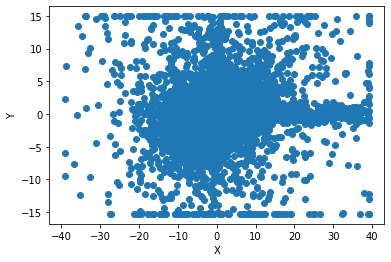

In [ ]:
plt.scatter(train_df['X'],y_train)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [ ]:
#creating the sequence 
time_step = 30 # kitne no of prior data ki memory rakhni hai
def create_sequence(X,y,ts=time_step):
  seq_in , seq_op = [],[]
  for i in range(len(X)-ts):
    seq_in.append(X.iloc[i:i+ts])
    seq_op.append(y.iloc[i+ts])

  return np.array(seq_in), np.array(seq_op)


In [ ]:
# using create sequence 
train_in,train_op = create_sequence(x_train,y_train)
print("before conversion from 2d-3d shape of train_in =",train_in.shape)
print(" shape of train_op =",train_op.shape)

n_feature = 1
#coverting it into 3D with n-features = 2 (ie. x,y)
train_in = train_in.reshape((train_in.shape[0], time_step, n_feature))
print("after conversion from 2d-3d shape of x_train =",train_in.shape)
print(" shape of train_op =",train_op.shape)


before conversion from 2d-3d shape of train_in = (305987, 30)
 shape of train_op = (305987, 1)
after conversion from 2d-3d shape of x_train = (305987, 30, 1)
 shape of train_op = (305987, 1)


In [ ]:
#creating LSTM autoencoder model
model = Sequential()

#encoder layer
model.add(LSTM(64, activation='tanh',return_sequences=True,input_shape=((time_step,n_feature))))
model.add(Dropout(rate=0.2))
model.add(LSTM(32, activation='tanh'))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(time_step))

#decoder layer
model.add(LSTM(64, activation='tanh',return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(n_feature)))

#compile the model
model.compile(optimizer='adam', loss ='mae')
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            16896     
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 repeat_vector (RepeatVector  (None, 30, 32)           0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 30, 64)            24832     
                                                        

In [ ]:
# train the model and returns the history object and stores in history
history=model.fit(train_in,train_op,epochs=10,batch_size =32,verbose=1,validation_split=0.01)

Epoch 1/10
9467/9467 [==============================] - 457s 48ms/step - loss: 0.5328 - val_loss: 0.3119
Epoch 2/10
9467/9467 [==============================] - 464s 49ms/step - loss: 0.5095 - val_loss: 0.3132
Epoch 3/10
9467/9467 [==============================] - 461s 49ms/step - loss: 0.5033 - val_loss: 0.2955
Epoch 4/10
9467/9467 [==============================] - 454s 48ms/step - loss: 0.4996 - val_loss: 0.2934
Epoch 5/10
9467/9467 [==============================] - 456s 48ms/step - loss: 0.4963 - val_loss: 0.2916
Epoch 6/10
9467/9467 [==============================] - 460s 49ms/step - loss: 0.4938 - val_loss: 0.3015
Epoch 7/10
9467/9467 [==============================] - 444s 47ms/step - loss: 0.4917 - val_loss: 0.2875
Epoch 8/10
9467/9467 [==============================] - 447s 47ms/step - loss: 0.4900 - val_loss: 0.2865
Epoch 9/10
9467/9467 [==============================] - 462s 49ms/step - loss: 0.4879 - val_loss: 0.2890
Epoch 10/10
9467/9467 [==============================] 

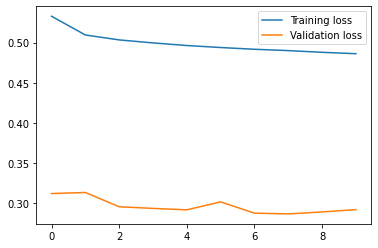

In [ ]:
# summary of loses
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [ ]:
#predict 
trainPredict = model.predict(x_train)
#reconstruction error
trainMAE = np.mean(np.abs(trainPredict - x_train), axis =1)
plt.hist(trainMAE,bins=30)


In [ ]:
# could not proceed further as the session kept crashing on the above step which gives the value of max_trainMAE 

In [ ]:
#setting the max threshold
max_trainMAE = 

In [ ]:
#capturing details in 1 dataframe
anamoly_df = pd.DataFrame(test_df[size:])
anamoly_df["test_MAE"]= testMAE
anamoly_df["max_trainMAE"]= max_trainMAE

anamoly_df['Anamoly']=anamoly_df['test_MAE']>anamoly_df['max_trainMAE']
anamoly_df['Y']= test_df.iloc[size: ]['Y']


In [ ]:
sns.lineplot(x=anamoly_df['X'],y=anamoly_df['testMAE'])
sns.lineplot(x=anamoly_df['X'],y=anamoly_df['max_testMAE'])



In [ ]:
anamolies= anamoly_df.loc[anamoly_df['Anamoly']]==True


In [ ]:
sns.lineplot(x=anamoly_df['X'],y=scaler.inverse_transform(anamoly_df['Y']))
sns.scatterplot(x=anamolies['X'],=scaler.inverse_transform(anamolies['Y']), color='r')
